# CompSci software project WS17/18 - 07.11.2017

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Lennard-Jones interaction in a periodic box

$$\phi_{\text{LJ}}(r) = 4\epsilon \left( \frac{\sigma^{12}}{r^{12}} - \frac{\sigma^6}{r^6} \right)$$

In [2]:
def potential_lj(r, sigma=1.0, epsilon=1.0, r_cut=3.0):
    if r >= r_cut:
        return 0.0
    q = (sigma / r)**6
    return 4.0 * (epsilon * (q * (q - 1.0)))

def pbc(r_vec, box):
    for i, length in enumerate(box):
        while r_vec[i] >= 0.5 * length:
            r_vec[i] -= length
        while r_vec[i] < -0.5 * length:
            r_vec[i] += length
    return r_vec

def potential(r_vec, box, sigma=1.0, epsilon=1.0):
    epot = 0.0
    for i, ri in enumerate(r_vec):
        epot_i = 0.0
        for rj in r_vec[i+1:]:
            r = np.linalg.norm(pbc(ri - rj, box))
            epot_i += potential_lj(r, sigma=sigma, epsilon=epsilon)
        epot += epot_i
    return epot

## Stochastic optimization

(-3, 0)

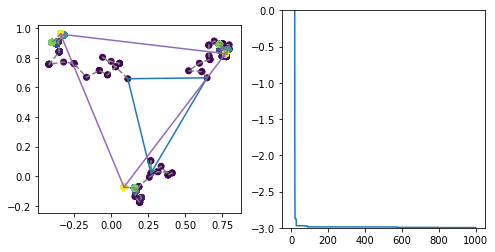

In [3]:
def greedy_step(r_vec, box, e_vec=None, width=0.2):
    if e_vec is None:
        e_vec = potential(r_vec, box)
    r_trial = r_vec + width * (np.random.rand(*r_vec.shape) - 0.5)
    e_trial = potential(r_trial, box)
    if e_trial < e_vec:
        return r_trial, e_trial
    return r_vec, e_vec

def opt(r_vec_init, n_steps, box, width=0.2):
    r_vec = [np.asarray(r_vec_init)]
    e_vec = [potential(r_vec[-1], box)]
    for i in range(n_steps):
        r, e = greedy_step(r_vec[-1], box, e_vec=e_vec[-1], width=width)
        r_vec.append(r)
        e_vec.append(e)
    return np.asarray(r_vec), np.asarray(e_vec)

r_opt, e_opt = opt(np.random.rand(3, 2), 1000, [6.0, 6.0])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i in range(3):
    axes[0].plot(*r_opt[:, i, :].T, '--', color='grey')
    axes[0].scatter(*r_opt[:, i, :].T, c=np.arange(len(r_opt)))
axes[0].set_aspect('equal')

for i, j in zip([0, 1, 2], [1, 2, 0]):
    axes[0].plot([r_opt[0, i, 0], r_opt[0, j, 0]], [r_opt[0, i, 1], r_opt[0, j, 1]], color='C0')
    axes[0].plot([r_opt[-1, i, 0], r_opt[-1, j, 0]], [r_opt[-1, i, 1], r_opt[-1, j, 1]], color='C4')

axes[1].plot(e_opt)
axes[1].set_ylim(-3, 0)

## Metropolis MCMC

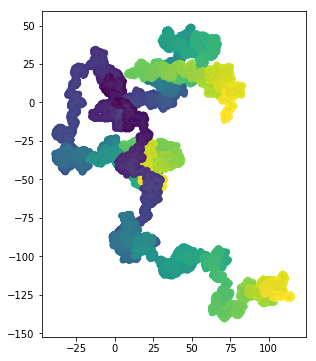

In [6]:
def mcmc_step(r_vec, box, e_vec=None, width=0.2):
    if e_vec is None:
        e_vec = potential(r_vec, box)
    r_trial = r_vec + width * (np.random.rand(*r_vec.shape) - 0.5)
    e_trial = potential(r_trial, box)
    if e_trial < e_vec or np.random.rand() < np.exp(e_vec - e_trial):
        return r_trial, e_trial
    return r_vec, e_vec

def mcmc(r_vec_init, n_steps, box, width=0.2, n_skip=1):
    r_vec = [np.asarray(r_vec_init)]
    e_vec = [potential(r_vec[-1], box)]
    r, e = r_vec[0], e_vec[0]
    for i in range(n_steps):
        for j in range(n_skip):
            r, e = mcmc_step(r, box, e_vec=e, width=width)
        r_vec.append(r)
        e_vec.append(e)
    return np.asarray(r_vec), np.asarray(e_vec)

r, e = mcmc(r_opt[-1], 10000, [6.0, 6.0], n_skip=100)

fig, ax = plt.subplots(figsize=(6, 6))
for i in range(3):
    ax.plot(*r[:, i, :].T, '--', color='grey', alpha=0.1)
    ax.scatter(*r[:, i, :].T, c=np.arange(r.shape[0]))
ax.set_aspect('equal')